In [52]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from shutil import copyfile
import os
import sys
import collections
import struct
import argparse
# from notebooks.utils import plot_images, plot_matches, add_frame

from hfnet.models import get_model  
import Image_functions
import  jsonparser
from hloc.utils import viz
from hloc import  visualization


In [53]:
### This is for robot lab trajectory 3 
"""
wget https://doc-0o-34-docs.googleusercontent.com/docs/securesc/dn5p05vfr786umosrqispvvcmjgtdss2/372kqi9edicbd5spm3jap91tqp96u537/1614659850000/09043507770403126626/09236460614078308514/12TPwjQ-8_cgm3XCYVnBmCPcV_pL7yh_P?e=download&authuser=1
"""
### Please download the dataset in datasets
### set the path to image where you have downloaded the imagews
### here i am using path to images for map as these will be used to create the map
path_to_images_for_map = Path("/home/Hierarchical-Localization/datasets/UsefulImagesT3")

In [54]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    print(len(image_path))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path

1637


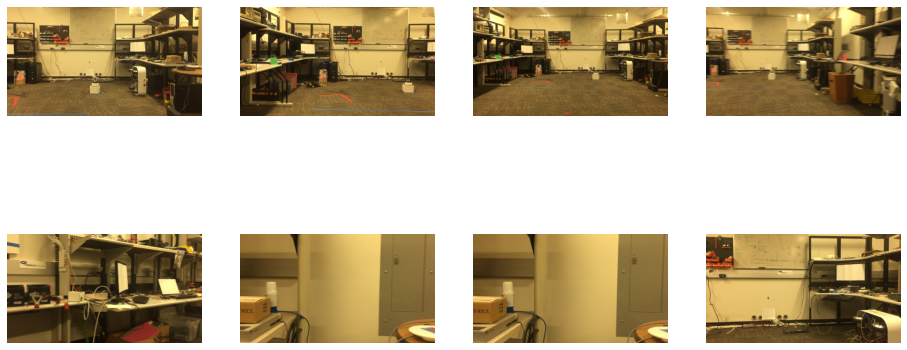

In [55]:
## image path will have path to all the images in it
## This will show 8 images 
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4)

In [56]:
# image dictionary creator gives image, its name and index as dictionary
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict

In [57]:
image_dict = dictionary_of_images(image_path)
print(len(image_dict))

1637it [00:15, 106.15it/s]

1637


In [58]:
# this finds the global matrix and create the h5 file for global features
# also return a dictionary with index, image name and the descriptor associated
def global_dict_matrix_and_H5_map(config, image_dict):
    predictions_dict = {}
    global_feature_path = (config["output"])/"global_features.h5"
    global_feature_file = h5py.File(str(global_feature_path), 'w')
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
            grp = global_feature_file.create_group(data['name'])
            grp.create_dataset('global_descriptor', data=predictions['global_descriptor'])
        global_feature_file.close()
    return predictions_dict, global_matrix

In [59]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)

In [60]:
# Writing the .txt file. 
# this funtion creates the .txt for global matches
# similar matches are automatically removed by matcher featurea 
##hence dont worry about it :)
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string) 

In [61]:
## here set the path for output 
#"""sfm_T3_pba""" 
output_path = Path("/home/Hierarchical-Localization/outputs/sfm_T3_pba")
output_path.mkdir(exist_ok =True, parents= True)

In [62]:
# here setting the path for weights saved for netVLAD
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")
# here config for global
config_global = {'output':output_path, 'checkpoint_path':checkpoint_path, 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         

In [63]:
# calling the function for global descriptor
global_dict_map, global_matrix = global_dict_matrix_and_H5_map(config_global, image_dict)

W0302 07:05:08.373040 140415290312512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0302 07:05:08.390029 140415290312512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0302 07:05:08.390793 140415290312512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0302 07:05:08.391801 140415290312512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0302 07:05:08.394505 140415290312512 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

In [64]:
# creating the txt file for matches
# here the last argument is the number of global matches you want to find
text_file_for_global_matches(global_dict_map, global_matrix,output_path,50)

100%|██████████| 1637/1637 [00:00<00:00, 13526.41it/s]


In [65]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
## this is the configuration for finding local features
## the name of the output file will be the 
### key for output in feature_conf_superpoint 

feature_conf_superpoint = {'output': 'features_superpoint', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}


In [68]:
## finds the local features and stores it as a h5 file
extract_features.main(feature_conf_superpoint,path_to_images_for_map,output_path)

I0302 07:07:18.630785 140415290312512 extract_features.py:123] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}
I0302 07:07:18.753274 140415290312512 extract_features.py:81] Found 1637 images in root /home/Hierarchical-Localization/datasets/UsefulImagesT3.
  0%|          | 0/1637 [00:00<?, ?it/s]

Loaded SuperPoint model


100%|██████████| 1637/1637 [00:18<00:00, 88.52it/s] 
I0302 07:07:37.300851 140415290312512 extract_features.py:160] Finished exporting features.


In [69]:
## this is the configuration for matching and it also gives a h5 filw
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = feature_conf_superpoint['output']

In [70]:
## this is the name of the file .txt for global matches
sfm_pairs = output_path/"global_feature.txt"

In [71]:
match_features.main(matcher_conf, sfm_pairs, features, output_path)


I0302 07:07:39.322574 140415290312512 match_features.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
  0%|          | 2/80213 [00:00<1:23:36, 15.99it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 80213/80213 [42:34<00:00, 31.40it/s]  
I0302 07:50:14.189457 140415290312512 match_features.py:113] Finished exporting matches.


In [72]:
## this is the directory where the sfm model will be saved
sfm_dir = output_path/'sfm_superpoint+superglue'

In [73]:
feature_file = output_path/'features_superpoint.h5'
match_file = output_path/'features_superpoint_matches-superglue_global_feature.h5'

In [74]:
## There are two optimizers pba and ceres 
# you can choose either one of them by seleting the pba option 


In [75]:
## This creates the SFM model
reconstruction.main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file, pba=True)

I0302 07:50:14.381074 140415290312512 reconstruction.py:16] Creating an empty database...
I0302 07:50:14.405833 140415290312512 reconstruction.py:25] Importing images into the database...
I0302 07:50:28.254131 140415290312512 triangulation.py:41] Importing features into the database...
100%|██████████| 1637/1637 [00:00<00:00, 2022.28it/s]
I0302 07:50:29.131090 140415290312512 triangulation.py:57] Importing matches into the database...
100%|██████████| 80213/80213 [00:27<00:00, 2899.84it/s]
I0302 07:50:57.802137 140415290312512 triangulation.py:98] Performing geometric verification of the matches...
I0302 07:51:55.806329 140415290312512 reconstruction.py:68] Running the 3D reconstruction...
I0302 07:51:55.808748 140415290312512 reconstruction.py:86] colmap mapper --database_path /home/Hierarchical-Localization/outputs/sfm_T3_pba/sfm_superpoint+superglue/database.db --image_path /home/Hierarchical-Localization/datasets/UsefulImagesT3 --output_path /home/Hierarchical-Localization/outputs/

In [80]:
## this function reads the original ground truth
names_trans_rot = jsonparser.parser("/home/Hierarchical-Localization/datasets/UsefulPosesT3GS2")

In [81]:
### Set the map in global reference frame 
#number of images minimum =3
## creating the txt file
def txt_file_for_geo_registration(output_path, using, number_of_images):
    file_name = 'output_world_file.txt'
    file_path = output_path/file_name
    using_list_keys = list(using.keys())
    with open(file_path, 'w') as f:    
        for i in range(number_of_images):
            image_name = using_list_keys[i]
            tvec = using[image_name]['tvec']
            if i ==0:
                string = image_name+ " "+ str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
            else:
                string = "\n" + image_name+ " "+str(tvec[0])+" "+ str(tvec[1])+" "+str(tvec[2])
            f.write(string)

In [111]:
## this creates a txt file which is the image with their global coordiantes
txt_file_for_geo_registration(output_path, names_trans_rot, 500)

In [112]:
## setting the map with global scale
### geo registration model directory
sfm_dir = output_path/'sfm_superpoint+superglue'
geo_registration_dir = sfm_dir/"geo_registered_model"
geo_registration_dir.mkdir(exist_ok = True)

import subprocess
cmd = ["colmap", "model_aligner",
       '--input_path', str(sfm_dir/"models"/"0"),
       '--output_path', str(geo_registration_dir),
       '--ref_images_path', str(output_path/'output_world_file.txt'),
       '--robust_alignment_max_error', str(20)]

ret = subprocess.call(cmd)
print (ret)
print("should print 0 if succesfull")

0
should print 0 if succesfull


In [113]:
## find the error within itself
## these funtion were copied from utilies and were made change according to the requierement
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)
def read_images_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for image_index in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_name] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images
def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])
def colmap_to_global(_tvec, _qvec):
    return -np.matmul(qvec2rotmat(_qvec).transpose(), _tvec)
def global_and_colmap(name, read_images_binary, using):
    tvec = using[name]['tvec']
    rvec = using[name]['rvec']
    tvec_colmap = read_images_binary[name][2]
    rvec_colmap = read_images_binary[name][1]
    CtG= colmap_to_global(tvec_colmap, rvec_colmap)
    return tvec, CtG
def error(tvec, CtG):
    return np.linalg.norm(tvec-CtG)
    

In [114]:
image_bin_path = geo_registration_dir/"images.bin"
## this gives the pose of every image in the geo registered map
ReadImagesBinary = read_images_binary(image_bin_path)

In [115]:
## this will create a .txt file with the errors  for GT and the map 
def within_itself(using, ReadImagesBinary, path):
    list_of_registered = list(ReadImagesBinary.keys())
    file_name = 'with_itself_map_and_GT.txt'
    error_list = []
    with open(path/file_name, 'w') as f:        
        for i  in range(len(list_of_registered)):
            tvec, CtG = global_and_colmap(list_of_registered[i], ReadImagesBinary, using)
            err = error(tvec, CtG)
            error_list.append(err)
            if i == 0:
                string = list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            else:
                string ='\n'+ list_of_registered[i]+ " " + str(tvec) + " " +str(CtG) + " " + str(err)
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = '\n'+"The median error is "+ str(np.median(error_list))
        f.write(string)
        string = '\n'+"The mean error is "+ str(np.mean(error_list))
        f.write(string)
        string = '\n'+"The max error is "+ str(np.max(error_list))
        f.write(string)  

In [116]:
within_itself(names_trans_rot, ReadImagesBinary, output_path)

In [117]:
## This function show the points in green which were registered and 
# in red the points which were not registered
def points_tracked(read_binary, image_name, image_dict):
    list_of_names_binary = list(read_binary.keys())
    if image_name not in list_of_names_binary:
        print("Image is not registered")
        return 
    keypoints_reduced = read_binary[image_name][-2] - 0.5
    points_id = read_binary[image_name][-1]
    points_tracked = keypoints_reduced[np.where(points_id!=-1)]
    points_not_tracked = keypoints_reduced[np.where(points_id==-1)]
    viz.plot_images([image_dict[image_name]['image']])
    viz.plot_keypoints([points_tracked], ps= 10)
    viz.plot_keypoints([points_not_tracked], ps=10, colors="red")

In [118]:
## as the image i the above are addressed with their name here a dicitonary images and their names is created
def dictionary_of_images_name(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[image_path[i].name] = {"image":image_array}
    return image_dict
dict_image_name = dictionary_of_images_name(image_path)

1637it [00:14, 110.54it/s]


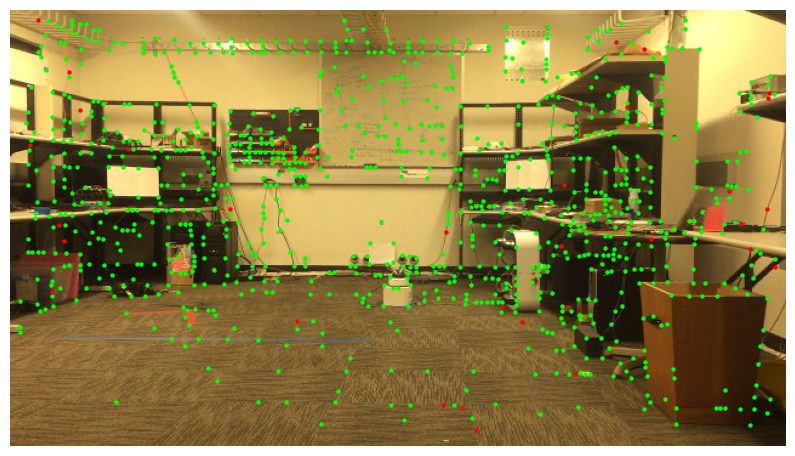

In [119]:
## send the image which you want to see
points_tracked(ReadImagesBinary,'iPhoSilWithWv3_1598592403_308-03780.png',dict_image_name )

2104


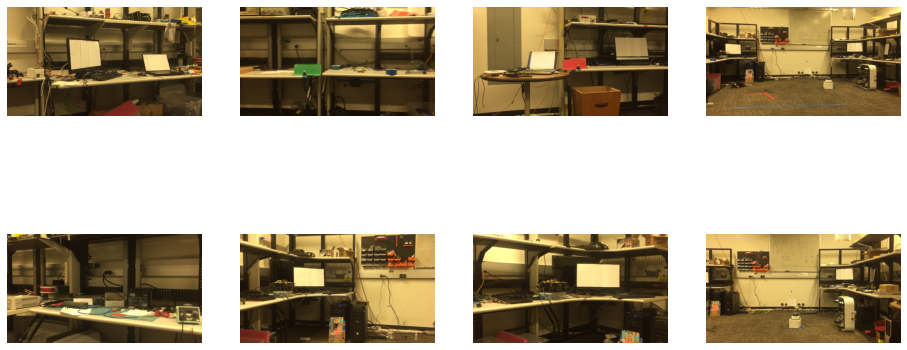

2104it [00:18, 111.48it/s]


In [121]:
## send the path to query images
path_to_query = Path("/home/Hierarchical-Localization/datasets/UsefulImagesT4")
## this will create a list with all the image path in it
image_path_query = image_directory_parser(path_to_query, viewer=True, number = 4)
# dictionary_of_images creator gives image, its name and index as dictionary
image_dict_query = dictionary_of_images(image_path_query)

In [122]:
## will find the global descriptor for query images

def global_dict_matrix_query(config, image_dict):
    predictions_dict = {}
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
    return predictions_dict, global_matrix

In [123]:
# calling the above function 
predicitons_dict_query, global_matric_query = global_dict_matrix_query(config_global, image_dict_query)

I0302 08:56:51.258282 140415290312512 base_model.py:411] Restoring variables: 
	vgg16_netvlad_pca/WPCA/bias
	vgg16_netvlad_pca/WPCA/kernel
	vgg16_netvlad_pca/assignment/kernel
	vgg16_netvlad_pca/average_rgb
	vgg16_netvlad_pca/cluster_centers
	vgg16_netvlad_pca/conv1_1/bias
	vgg16_netvlad_pca/conv1_1/kernel
	vgg16_netvlad_pca/conv1_2/bias
	vgg16_netvlad_pca/conv1_2/kernel
	vgg16_netvlad_pca/conv2_1/bias
	vgg16_netvlad_pca/conv2_1/kernel
	vgg16_netvlad_pca/conv2_2/bias
	vgg16_netvlad_pca/conv2_2/kernel
	vgg16_netvlad_pca/conv3_1/bias
	vgg16_netvlad_pca/conv3_1/kernel
	vgg16_netvlad_pca/conv3_2/bias
	vgg16_netvlad_pca/conv3_2/kernel
	vgg16_netvlad_pca/conv3_3/bias
	vgg16_netvlad_pca/conv3_3/kernel
	vgg16_netvlad_pca/conv4_1/bias
	vgg16_netvlad_pca/conv4_1/kernel
	vgg16_netvlad_pca/conv4_2/bias
	vgg16_netvlad_pca/conv4_2/kernel
	vgg16_netvlad_pca/conv4_3/bias
	vgg16_netvlad_pca/conv4_3/kernel
	vgg16_netvlad_pca/conv5_1/bias
	vgg16_netvlad_pca/conv5_1/kernel
	vgg16_netvlad_pca/conv5_2/bias


In [124]:
## creates the global matches txt file for query with map 
def query_global_txt_file_creator(image_dict_query, image_dict_map, global_matrix, predictions_dict_query, path, file_name, number):
    with open(path/file_name, 'w') as f:
        for i in tqdm(range(len(predictions_dict_query))):
            current_descriptor = predictions_dict_query[i]["global_descriptor"]
            neighbours = compute_distance(current_descriptor, global_matrix)
            global_matches = ((np.argsort(neighbours))[:number])
            for j in range(len(global_matches)):
                if i == 0 and j ==0:
                    string = image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                else:
                    string = "\n"+ image_dict_query[i]["name"]+ " "+ image_dict_map[global_matches[j]]["name"]
                f.write(string) 

In [125]:
## callling the above funtion 
## take in input as the dictionary of map image
##dict of query images
## global matrix of map image
## global descriptor image dict of query images
global_file_txt = "global_image_query.txt"
query_global_txt_file_creator(image_dict_query, image_dict, global_matrix, predicitons_dict_query, output_path, global_file_txt, 10)

100%|██████████| 2104/2104 [00:00<00:00, 2508.29it/s]


In [126]:
## local image conf for query images here the only different is output
feature_conf_superpoint_query = {'output': 'features_superpoint_query', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}

In [127]:
## calling the local feature extractor function 
extract_features.main(feature_conf_superpoint_query,path_to_query,output_path)

I0302 08:58:50.651447 140415290312512 extract_features.py:123] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint_query',
 'preprocessing': {'grayscale': True, 'resize_max': 960}}
I0302 08:58:50.777826 140415290312512 extract_features.py:81] Found 2104 images in root /home/Hierarchical-Localization/datasets/UsefulImagesT4.
  0%|          | 0/2104 [00:00<?, ?it/s]

Loaded SuperPoint model


100%|██████████| 2104/2104 [00:23<00:00, 88.65it/s] 
I0302 08:59:14.550350 140415290312512 extract_features.py:160] Finished exporting features.


In [128]:
## setting the configuration for matches query (superglue)
matcher_conf_query = {'output': 'matches-superglue_query', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features_query = feature_conf_superpoint_query['output']
loc_pairs = output_path/global_file_txt

In [129]:
## this matcheer is differnt as it needs feature both for the query imags and map images
from hloc import feature_matcher_map_query
feature_matcher_map_query.main(matcher_conf_query, loc_pairs, features, output_path, features_query)

I0302 08:59:18.269037 140415290312512 feature_matcher_map_query.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue_query'}
I0302 08:59:18.270802 140415290312512 feature_matcher_map_query.py:50] Using query_features features_superpoint_query
  0%|          | 2/21040 [00:00<17:54, 19.57it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 21040/21040 [18:00<00:00, 19.47it/s]
I0302 09:17:19.130347 140415290312512 feature_matcher_map_query.py:127] Finished exporting matches.


In [130]:
## this creates a .txt file for queries and their camera intricsics
filename = "queries_choosen_with_intrinsics.txt"
with open(output_path/filename, 'w') as f:
    for i in range(len(image_path_query)):
        name = image_path_query[i].name
        if i ==0:
            string = str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        else:
            string = "\n"+  str(name) + " "+ "SIMPLE_RADIAL"+ " " +str(640)+ " "+ str(480)+" " + str(658.503)+ " "+str(320)+ " " + str(180) + " "+str(0.0565491)
        f.write(string)

In [131]:
from hloc import localize_sfm

localize_sfm.main(geo_registration_dir,
                 output_path/"queries_choosen_with_intrinsics.txt",
                 loc_pairs,
                 output_path/'features_superpoint_query.h5',
                 output_path/'features_superpoint_matches-superglue_query_global_image_query.h5',
                 output_path/'results_query.txt',
                 covisibility_clustering=False)

I0302 09:25:01.038537 140415290312512 parsers.py:16] Importing 2104 queries in queries_choosen_with_intrinsics.txt
I0302 09:25:01.074719 140415290312512 localize_sfm.py:108] Reading 3D model...
I0302 09:25:03.001996 140415290312512 localize_sfm.py:122] Starting localization...
100%|██████████| 2104/2104 [03:59<00:00,  8.78it/s]
I0302 09:29:02.552981 140415290312512 localize_sfm.py:182] Localized 2104 / 2104 images.
I0302 09:29:02.554258 140415290312512 localize_sfm.py:183] Writing poses to /home/Hierarchical-Localization/outputs/sfm_T3_pba/results_query.txt...
I0302 09:29:02.602967 140415290312512 localize_sfm.py:193] Writing logs to /home/Hierarchical-Localization/outputs/sfm_T3_pba/results_query.txt_logs.pkl...
I0302 09:29:16.175812 140415290312512 localize_sfm.py:196] Done!


In [132]:
## to visualize tracked points
from hloc import  visualization
local_feature_path = output_path/'features_superpoint.h5'
local_feature_path_query = output_path/'features_superpoint_query.h5'
visualization.visualize_loc_new(
    output_path/'results_query.txt', path_to_images_for_map,path_to_query,local_feature_path, local_feature_path_query, geo_registration_dir , n=10, top_k_db=1, seed=2)

AttributeError: module 'hloc.visualization' has no attribute 'visualize_loc_new'

In [133]:
## ground truth for query images
names_trans_rot_query = jsonparser.parser("/home/Hierarchical-Localization/datasets/UsefulPosesT4HH")

In [134]:
len(names_trans_rot_query)

2104

In [135]:
def file_creator_error(original_dict_json, file_name_read, file_name_write, path):
    list_of_registered = list(original_dict_json.keys())
    with open(path/file_name_read, 'r') as f:
        Lines = f.readlines()
    error_list = []
    with open(path/file_name_write, 'w') as f:
        for line in Lines:
            line = line.split()
            name = line[0]
            qvec = np.asarray(line[1:5], dtype=np.float32)
#             qvec = np.array([line[2], line[3], line[4], line[1]],dtype=np.float32)
            tvec = np.asarray(line[5:8], dtype=np.float32)
            tvec_world = colmap_to_global(tvec, qvec)
            tvec_ori = original_dict_json[name]["tvec"]
            er =  error(tvec_world, tvec_ori)
            error_list.append(er)
            string = name + " "+ str(tvec_ori)+ " "+str(tvec_world)+ " " + str(er)+ "\n"
            f.write(string)
        error_list = np.asarray(error_list,  dtype=np.float32)
        string = "The median error is "+ str(np.median(error_list))+ '\n'
        f.write(string)
        string = "The mean error is "+ str(np.mean(error_list))+ '\n'
        f.write(string)
        string = "The max error is "+ str(np.max(error_list))
        f.write(string)

In [137]:
file_creator_error(names_trans_rot_query,'results_query.txt', "results_query_error.txt", output_path)